# How To Export a YOLOv5 Model Trained in Supervisely

After you have trained a model using Train YOLOv5 app, you can download the best checkpoint from Team Files and use your trained YOLOv5 model outside Supervisely Platform.

## 1. Download checkpoint from Team Files

1. Go to Team Files

![team_files_1](https://github.com/supervisely-ecosystem/yolov8/assets/91027877/d95a548b-e7dd-4e4a-a1fa-0c7a62ad62ac)

2. Download trained checkpoint

![team_files_4](https://github.com/supervisely-ecosystem/yolov5/assets/91027877/b7014d22-8c2e-4ca7-a7b4-cc9c14661ccd)

Alternatively, you can download these files using Supervisely API:

In [ ]:
# Install supervisely SDK if not installed
!pip install supervisely

To download files via Supervisely API, you will need to define [server address](https://developer.supervisely.com/getting-started/basics-of-authentication#server_address-env), [api token](https://developer.supervisely.com/getting-started/basics-of-authentication#api_token-env) and [team id](https://developer.supervisely.com/getting-started/environment-variables#team_id):

In [ ]:
import supervisely as sly


server_address = "https://..."
api_token = "abcd0123456789..."
team_id = ...
path_to_weights_in_team_files = ...
download_dir = "./my_model"

api = sly.Api(server_address, api_token)
api.file.download(team_id, path_to_weights_in_team_files, f"{download_dir}/weights.pth")

## 2. Install necessary libraries

You can also use [this Dockerfile](https://github.com/supervisely-ecosystem/yolov5/blob/master/Dockerfile) to install necessary dependancies

## 3. Build the model and load it on device

In [1]:
import torch
from models.experimental import attempt_load

weights_path = "./my_model/weights.pt"
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
model = attempt_load(weights_path, map_location=device)

## 4. Inference & visualization of results

Let's see how input image looks like:

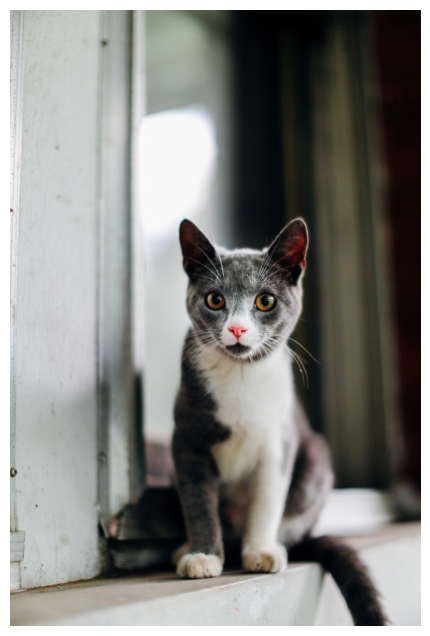

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# function for image visualization
def visualize_image(image_filepath):
    plt.figure(figsize=(12, 8))
    image = mpimg.imread(image_filepath)
    imageplot = plt.imshow(image)
    plt.axis("off")
    plt.show()

image_path = "data/images/cat.jpg"
visualize_image(image_path)

In [5]:
# run this code if you want to use new pytorch versions
# import torch.nn as nn

# for m in model.modules():
#     if isinstance(m, nn.Upsample):
#         m.recompute_scale_factor = None

In [6]:
from PIL import Image
import numpy as np
from utils.datasets import letterbox
from utils.general import check_img_size, non_max_suppression, scale_coords
import cv2

input_image = Image.open(image_path, "r")
input_image = np.asarray(input_image, dtype=np.float32)
img0 = input_image
stride = int(model.stride.max())
imgsz = 640
imgsz = check_img_size(imgsz, s=stride)
input_image = letterbox(input_image, new_shape=imgsz, stride=stride)[0]
input_image = input_image.transpose(2, 0, 1)
input_image = np.ascontiguousarray(input_image)
input_image = torch.from_numpy(input_image).to(device)
input_image /= 255.0
if input_image.ndimension() == 3:
    input_image = input_image.unsqueeze(0)

inf_out = model(input_image, augment=False)[0]
output = non_max_suppression(inf_out, conf_thres=0.25, iou_thres=0.45, agnostic=False)
for det in output:
    if det is not None and len(det) > 0:
        det[:, :4] = scale_coords(input_image.shape[2:], det[:, :4], img0.shape).round()
        for *xyxy, conf, cls in reversed(det):
            top, left, bottom, right = int(xyxy[1]), int(xyxy[0]), int(xyxy[3]), int(xyxy[2])
            print(f"Class: {cls}, confidence: {conf}, coordinates: {[top, left, bottom, right]}")
            cv2.rectangle(img0, (left, top), (right, bottom), color=(255, 0, 0), thickness=7)
            cv2.putText(
                img0,
                "cat",
                (left, top - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1.6,
                color = (255, 0, 0),
                thickness=7
            )
img0 = img0[:, :, ::-1]
cv2.imwrite("data/images/cat_prediction.jpg", img0)

Class: 15.0, confidence: 0.8009416460990906, coordinates: [647, 488, 1916, 1231]


/Users/maxteselkin/Coding/supervisely_projects/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


True

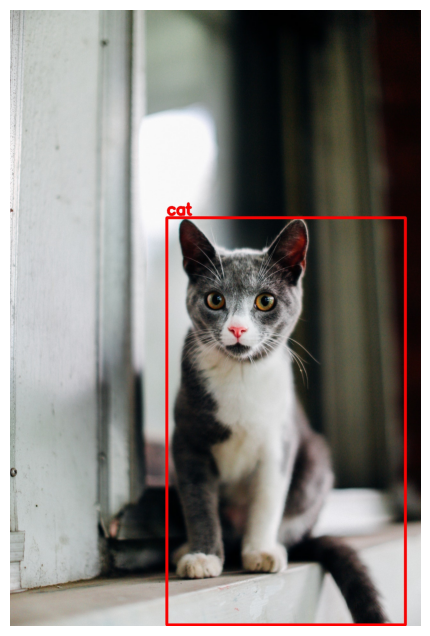

In [7]:
visualize_image("data/images/cat_prediction.jpg")